In [273]:
import warnings
warnings.filterwarnings('ignore')

In [274]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import pandas.plotting as pd_plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import load_breast_cancer 
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [275]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загружаем необходимые для анализа данные

In [276]:
gender_submission = pd.read_csv('gender_submission.csv')

In [277]:
gender_submission.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [278]:
tab = pd.read_csv('train.csv')

In [279]:
tab.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [283]:
len(list(tab.columns))

12

In [284]:
len(df)

418

In [189]:
# соединяем таблицы с данными по потенциальным признакам и целевой переменной

# tab = test_data.merge(gender_submission, how = 'left', on = 'PassengerId')

In [190]:
# tab.head(2)

In [191]:
# Переменные PassengerId, Name, Ticket, Cabin не имеют информативности для дальнейшего анализа
# Поэтому исключаем их

data = tab[['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass', 'Survived']]

### Посмотрим на данные, с которыми будем работать

In [192]:
# Количество строк и столбцов (форма)

data.shape

(891, 8)

In [193]:
# Типы данных по столбцам

data.dtypes

Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
Pclass        int64
Survived      int64
dtype: object

In [194]:
# Видим, что среди 7 признаков 2 переменные имеют тип object
# Нужно убедиться, что переменные категориальные

for col_name in data.columns:
    if data[col_name].dtypes == 'object':
        unique_cat = len(data[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".\
              format(col_name=col_name, unique_cat=unique_cat))

Feature 'Sex' has 2 unique categories
Feature 'Embarked' has 4 unique categories


In [249]:
bridge_df = tab.copy()

In [250]:
bridge_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [272]:
# end_df = pd.DataFrame(enc.fit_transform(bridge_df[['Embarked']].dropna()).toarray(),\
#                       columns = bridge_df['Embarked'].dropna().unique())

In [195]:
# Поскольку категории нельзя варьировать, переведем их в бинарные переменные, увеличив количество признаков

data['Cherbourg'] = (data['Embarked'] == 'C').astype(np.int)
data['Queenstown'] = (data['Embarked'] == 'Q').astype(np.int)
data['Southampton'] = (data['Embarked'] == 'S').astype(np.int)
data['Sex_'] = (data['Sex'] == 'female').astype(np.int)

In [271]:
data.head(2)

,Age,SibSp,Parch,Fare,Pclass,Survived,Cherbourg,Queenstown,Southampton,Sex_
0,22.0,1,0,7.2500,3,0,0,0,1,0
1,38.0,1,0,71.2833,1,1,1,0,0,1


In [196]:
# удалим переменные, которые переведены в бинарные

data.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [197]:
data.head(2)

,Age,SibSp,Parch,Fare,Pclass,Survived,Cherbourg,Queenstown,Southampton,Sex_
0,22.0,1,0,7.2500,3,0,0,0,1,0
1,38.0,1,0,71.2833,1,1,1,0,0,1


### Много ли пропусков в данных?

In [198]:
# Посмотреть, сколько пустых значений в каждом столбце

data.isnull().sum()

Age            177
SibSp            0
Parch            0
Fare             0
Pclass           0
Survived         0
Cherbourg        0
Queenstown       0
Southampton      0
Sex_             0
dtype: int64

**Видим, что больше всего пропусков в столбце Age и один пропуск в столбце Fare. Заменим пустые значения средними по признакам**

In [199]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(data)
data_2 = pd.DataFrame(data=imp.transform(data) , columns=data.columns)

**Проверим, прошла ли замена успешно?**

In [200]:
data_2.isnull().sum()

Age            0
SibSp          0
Parch          0
Fare           0
Pclass         0
Survived       0
Cherbourg      0
Queenstown     0
Southampton    0
Sex_           0
dtype: int64

### Сбалансированная ли выборка?

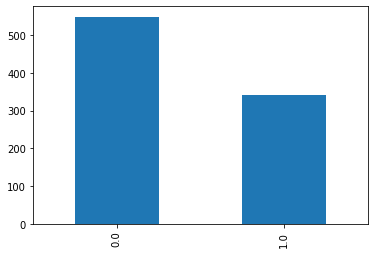

In [201]:
fig, ax = plt.subplots()
data_2['Survived'].value_counts().plot(ax=ax, kind='bar')

In [202]:
# сколько объектов каждого класса в столбце

data_2['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

In [203]:
# сколько всего объектов в столбце

len(data_2['Survived'])

891

In [204]:
# найдем процент каждого класса в общем числе элементов в столбце

print('Доля объектов класса "1": {} %'.\
      format(int((data_2['Survived'].value_counts()[0])/len(data_2['Survived'])*100)))

print('Доля объектов класса "0": {} %'.\
      format(int((data_2['Survived'].value_counts()[1])/len(data_2['Survived'])*100)))

Доля объектов класса "1": 61 %
Доля объектов класса "0": 38 %


**В принципе выборку можно считать сбалансированной, если полагаться на негласное правило 10 %. В нашем классе доля объектов каждого класса больше 10 %, поэтому можно попробовать построить модель.**

### Формируем выборки для обучения и теста

In [205]:
# Таблица с признаками

X = data_2[['Age', 'SibSp', 'Parch', 'Fare', 'Cherbourg', 'Pclass', 'Queenstown', 'Southampton', 'Sex_']]

In [206]:
# Целевая переменная

y = data_2['Survived']

In [207]:
# Делим выборку

X_train, X_validation, y_train, y_validation = train_test_split(X, y,
                                                 random_state = 0)

### Приступаем к отбору параметров

- GradientBoostingClassifier

In [208]:
# Use 'Grid Search' to find the best set of GB regression parameters 
# using full dataset with criterion = 'accuracy' and 
# random_state = 33

n_estimators = [50, 100, 150, 200]
max_features = [4, 6, 9]
max_depth = [5, 6, 7]
min_split = [2, 3, 4] 
min_leaf = [1, 2, 3]
best_score = 100

for n in n_estimators:
    for f in max_features:
        for d in max_depth:
            for s in min_split:   
                for l in min_leaf:
                     gb = GradientBoostingClassifier(
                     n_estimators = n, 
                     max_features= f,
                     random_state = 33,
                     max_depth = d, min_samples_split = s, 
                     min_samples_leaf = l)
            gb.fit (X_train, y_train)    
            #y_model = rf.predict(X_validation)
            #score = mean_absolute_error(y, y_model)
            score = np.mean(cross_val_score(gb, X_train, y_train, cv=4, scoring = 'accuracy'))
            if score <= best_score:
                best_score = score
                max_n = n
                max_f = f
                max_d = d
                max_s = s
                max_l = l


print ("Number of Estimators:", max_n)               
print ("Max features:", max_f)
print ("Max Depth:", max_d)
print ("Min Split:", max_s)
print ("Min Leaf:", max_l)
print("Best Accuracy: {:.3f}".format(best_score))

Number of Estimators: 200
Max features: 4
Max Depth: 7
Min Split: 4
Min Leaf: 3
Best Accuracy: 0.772


**Задаем классификатор с отобранными параметрами и обучаем**

In [169]:
# Fit a RF using best indentified parameters

gb = GradientBoostingClassifier(n_estimators=200, max_features=9, random_state = 33,
                           max_depth=7, min_samples_split=4, min_samples_leaf=3)

gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=7,
                           max_features=9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=33, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

**Строим прогнозы**

In [231]:
# Predict test instances using test dataframe (X_validation)

y_prediction_GB = gb.predict(X_validation)
y_prediction_GB

array([0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1.])

**Попробуем оценить качество построенных прогнозов**

In [242]:
# посмотрим на таблицу с метриками качества

# accuracy_score = accuracy_score(y_validation, y_prediction_GB)
# precision_score(y_validation, y_prediction_GB)
# recall_score(y_validation, y_prediction_GB)

print(classification_report(y_validation, y_prediction_GB))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87       139
         1.0       0.79      0.77      0.78        84

    accuracy                           0.84       223
   macro avg       0.83      0.83      0.83       223
weighted avg       0.84      0.84      0.84       223



**Показывает очень хорошее качество прогноза. Слишком хорошее, чтобы быть правдой.**

**Попробуем построить ROC-кривую**

In [233]:
fpr, tpr, _ = roc_curve(y_validation, y_prediction_GB)

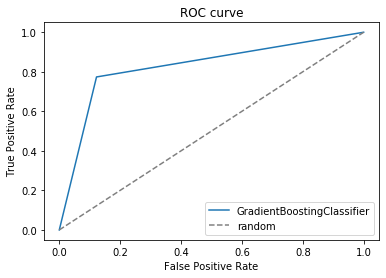

In [234]:
pylab.plot(fpr, tpr, label = 'GradientBoostingClassifier')
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve')
pylab.legend(loc = "lower right") # подпись справа внизу

In [223]:

cancer = load_breast_cancer()


# X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=10, test_size=0.2)


kfold = KFold(n_splits=7, shuffle=True, random_state=11)

pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', SVC())])

svc_gamma=[0.001, 0.01, 0.1, 1, 10, 100]
svc_C=[0.001, 0.01, 0.1, 1, 10, 100]

param_grid =[
    {'classifier': [SVC()], 
     'preprocessing': [None,StandardScaler()],
     'classifier__gamma': svc_gamma,
     'classifier__C': svc_C
     },
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 
     'classifier__max_features': [1, 2, 3]
    },
    {'classifier': [GradientBoostingClassifier(n_estimators=100)],
     'preprocessing': [None], 
     'classifier__max_depth': [1, 2, 3, 4, 5],
     'classifier__learning_rate':[0.05, 0.1, 0.2]
    }
]


grid = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)
grid.fit(X_train,y_train)

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
print("Средняя правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_validation, y_validation)))
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)

----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'classifier': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 1, 'classifier__gamma': 0.1, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Средняя правильность для наилучшей модели кроссвалидации на валидационных тестовых наборах: 0.826488

Средняя правильность для наилучшей модели на тестовом наборе: 0.802691



,41,82,78,63,77,76,83,53,81,87,...,20,21,22,23,25,28,30,34,14,0
mean_fit_time,0.00675842,0.0785874,0.0886346,0.0124292,0.0649023,0.0506792,0.0956669,0.00873119,0.0564346,0.0722871,...,0.00730532,0.0080362,0.00659817,0.00869008,0.00850119,0.00835701,0.00895296,0.00680903,0.00710334,0.00837336
std_fit_time,0.000219762,0.00918441,0.00248434,0.00155065,0.000954267,0.000788441,0.00937398,0.000400534,0.00483697,0.00822863,...,0.000169814,0.000161706,0.000246098,0.00014564,0.000668881,0.000649947,0.000225108,0.000121611,0.000211388,0.000835678
mean_score_time,0.00107946,0.00122486,0.00130803,0.00102261,0.000933238,0.000870228,0.0011394,0.00104652,0.00109853,0.00109145,...,0.00131641,0.00145037,0.00124042,0.00163531,0.00165657,0.00163899,0.00156638,0.00115592,0.00132431,0.0017349
std_score_time,4.70328e-05,0.000188981,0.000510081,1.28148e-05,8.98938e-05,4.74379e-05,0.000143102,5.07059e-05,0.000156074,0.000190308,...,3.35429e-05,5.82285e-05,7.12067e-05,7.62115e-05,0.000209199,0.000206344,9.11905e-05,3.03151e-05,2.75173e-05,0.000273926
param_classifier,"SVC(C=1, break_ties=False, cache_size=200, cla...","GradientBoostingClassifier(ccp_alpha=0.0, crit...","GradientBoostingClassifier(ccp_alpha=0.0, crit...","SVC(C=1, break_ties=False, cache_size=200, cla...","GradientBoostingClassifier(ccp_alpha=0.0, crit...","GradientBoostingClassifier(ccp_alpha=0.0, crit...","GradientBoostingClassifier(ccp_alpha=0.0, crit...","SVC(C=1, break_ties=False, cache_size=200, cla...","GradientBoostingClassifier(ccp_alpha=0.0, crit...","GradientBoostingClassifier(ccp_alpha=0.0, crit...",...,"SVC(C=1, break_ties=False, cache_size=200, cla...","SVC(C=1, break_ties=False, cache_size=200, cla...","SVC(C=1, break_ties=False, cache_size=200, cla...","SVC(C=1, break_ties=False, cache_size=200, cla...","SVC(C=1, break_ties=False, cache_size=200, cla...","SVC(C=1, break_ties=False, cache_size=200, cla...","SVC(C=1, break_ties=False, cache_size=200, cla...","SVC(C=1, break_ties=False, cache_size=200, cla...","SVC(C=1, break_ties=False, cache_size=200, cla...","SVC(C=1, break_ties=False, cache_size=200, cla..."
param_classifier__C,1,NaN,NaN,100,NaN,NaN,NaN,10,NaN,NaN,...,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.01,0.001
param_classifier__gamma,0.1,NaN,NaN,0.01,NaN,NaN,NaN,0.1,NaN,NaN,...,10,10,100,100,0.001,0.1,1,100,0.01,0.001
param_preprocessing,"StandardScaler(copy=True, with_mean=True, with...",None,None,"StandardScaler(copy=True, with_mean=True, with...",None,None,None,"StandardScaler(copy=True, with_mean=True, with...",None,None,...,None,"StandardScaler(copy=True, with_mean=True, with...",None,"StandardScaler(copy=True, with_mean=True, with...","StandardScaler(copy=True, with_mean=True, with...",None,None,None,None,None
param_classifier__max_features,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_classifier__learning_rate,NaN,0.1,0.05,NaN,0.05,0.05,0.1,NaN,0.1,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
print ('Оценка модели с лучшими параметрами\n',grid.best_score_)
print ('Лучшие наборы параметров\n', grid.best_params_)

Оценка модели с лучшими параметрами
 0.8264880952380952
Лучшие наборы параметров
 {'classifier': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 1, 'classifier__gamma': 0.1, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [225]:
# модель с лучшими параметрами
grid.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessing',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.1, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [227]:
# grid.cv_results_